# In this notebook we build ARIMA model for Monthly Milk production(pounds per cow) dataset and make prediction .

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('monthly-milk-production-pounds-p.csv')

In [3]:
df.head()

,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [4]:
df.tail()

,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
164,1975-09,817.0
165,1975-10,827.0
166,1975-11,797.0
167,1975-12,843.0
168,Monthly milk production: pounds per cow. Jan 6...,NaN


In [5]:
df.columns = ['Month','Milk in pounds per cow']
df.head()

,Month,Milk in pounds per cow
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [6]:
df.drop(168,axis=0,inplace=True)

In [7]:
df.head()

,Month,Milk in pounds per cow
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [8]:
df['Month'] = pd.to_datetime(df['Month'])

In [9]:
df.head()

,Month,Milk in pounds per cow
0,1962-01-01,589.0
1,1962-02-01,561.0
2,1962-03-01,640.0
3,1962-04-01,656.0
4,1962-05-01,727.0


In [10]:
df.set_index('Month',inplace=True)

In [11]:
df.head()

,Milk in pounds per cow
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0


In [12]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Milk in pounds per cow,168.0,754.708333,102.204524,553.0,677.75,761.0,824.5,969.0


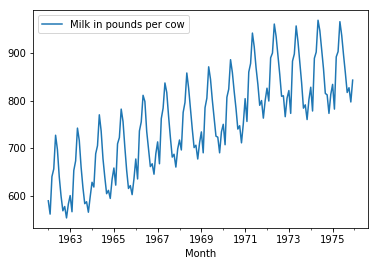

In [13]:
df.plot()

In [15]:
timeseries = df['Milk in pounds per cow']

<function matplotlib.pyplot.legend>

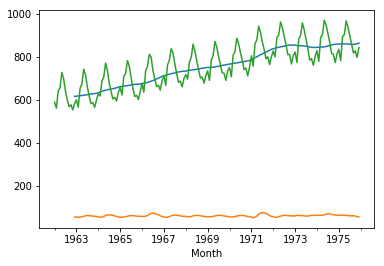

In [16]:
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.rolling(12).std().plot(label='12 Month Rolling Std')
timeseries.plot()
plt.legend

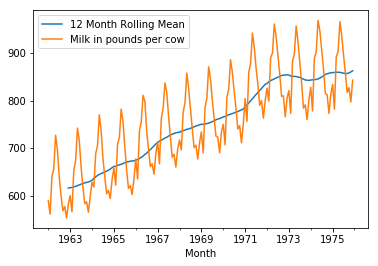

In [17]:
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.plot()
plt.legend()

## Decomposition

<Figure size 432x288 with 0 Axes>

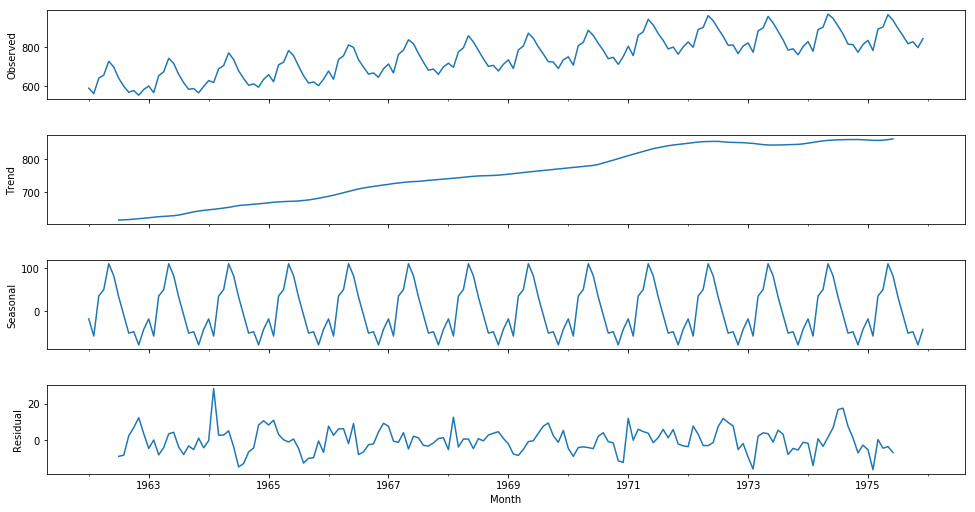

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Milk in pounds per cow'], freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [19]:
df.head()

,Milk in pounds per cow
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0


In [20]:
from statsmodels.tsa.stattools import adfuller

In [21]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

## First time series difference

In [22]:
df['Milk First Difference'] = df['Milk in pounds per cow'] - df['Milk in pounds per cow'].shift(1)

In [23]:
adf_check(df['Milk First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -3.054995558653052
p-value : 0.030068004001787108
#Lags Used : 14
Number of Observations Used : 152
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


## Seasonal Difference

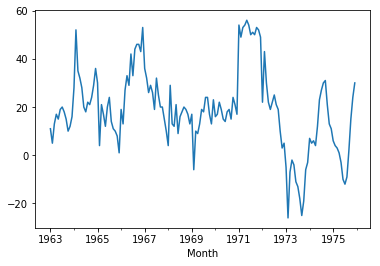

In [25]:
df['Seasonal Difference'] = df['Milk in pounds per cow'] - df['Milk in pounds per cow'].shift(12)
df['Seasonal Difference'].plot()

In [26]:
# Run dickey-fuller test!
adf_check(df['Seasonal Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.3354193143593975
p-value : 0.16079880527711365
#Lags Used : 12
Number of Observations Used : 143
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


## Seasonal first difference

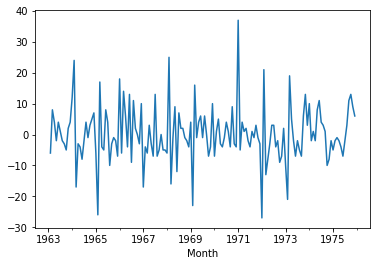

In [27]:
df['Seasonal First Difference'] = df['Milk First Difference'] - df['Milk First Difference'].shift(12)
df['Seasonal First Difference'].plot()

In [28]:
adf_check(df['Seasonal First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.038002274921977
p-value : 1.8654234318788898e-05
#Lags Used : 11
Number of Observations Used : 143
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [29]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

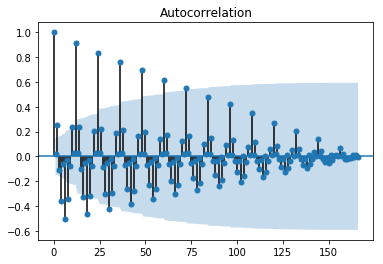

In [30]:
fig_first = plot_acf(df["Milk First Difference"].dropna())

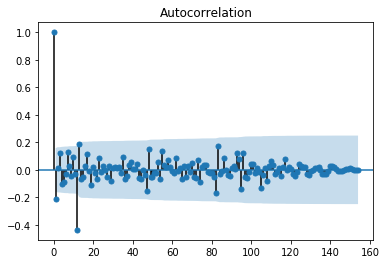

In [31]:
fig_seasonal_first = plot_acf(df["Seasonal First Difference"].dropna())

In [35]:
#Final ACF and PACF for seasonal first difference

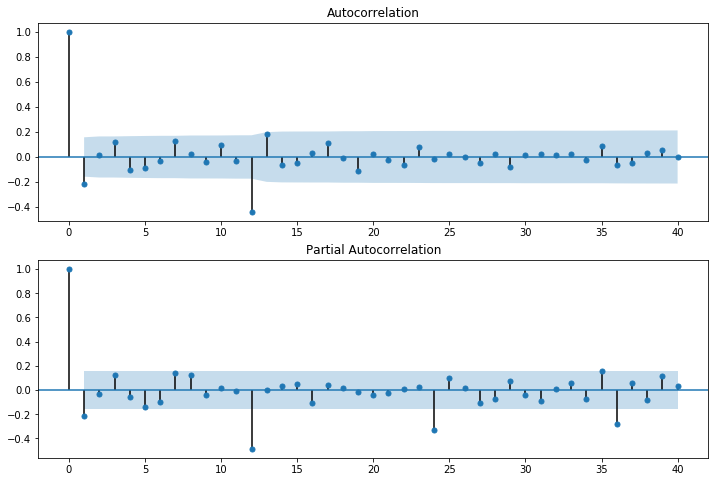

In [36]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].iloc[13:], lags=40, ax=ax2)

## Using seasonal ARIMA

In [37]:
from statsmodels.tsa.arima_model import ARIMA

In [38]:
# We have seasonal data!
model = sm.tsa.statespace.SARIMAX(df['Milk in pounds per cow'],order=(0,1,0), seasonal_order=(1,1,1,12))
results = model.fit()
print(results.summary())

/usr/local/Cellar/python3/3.5.2_3/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:             Milk in pounds per cow   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -534.065
Date:                            Thu, 05 Jul 2018   AIC                           1074.131
Time:                                    15:08:04   BIC                           1083.261
Sample:                                01-01-1962   HQIC                          1077.839
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0449      0.106     -0.422      0.673      -0.253       0.163
ma.S.L12      -0.5860      0.102   

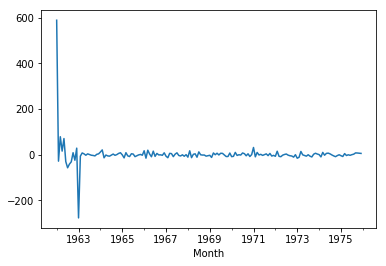

In [39]:
results.resid.plot()

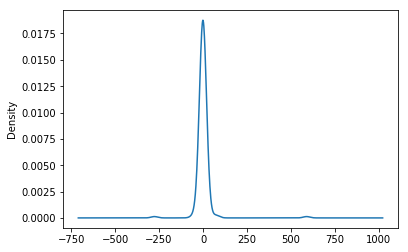

In [40]:
results.resid.plot(kind='kde')

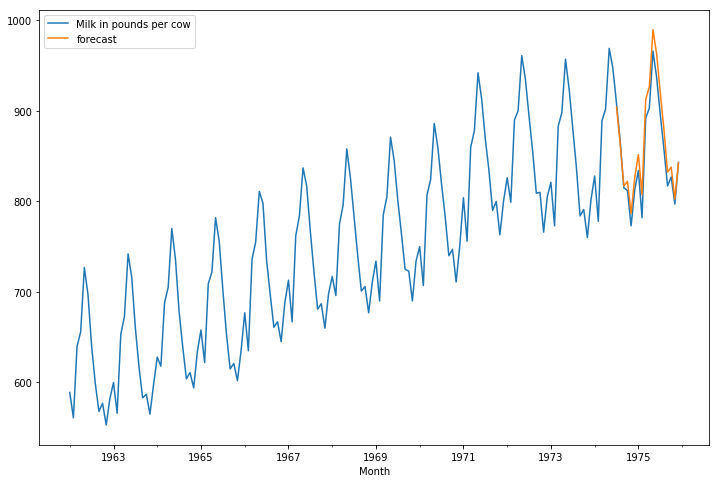

In [41]:
df['forecast'] = results.predict(start = 150, end= 168, dynamic= True)  
df[['Milk in pounds per cow','forecast']].plot(figsize=(12,8))

In [42]:
df.tail()

,Milk in pounds per cow,Milk First Difference,Seasonal Difference,Seasonal First Difference,forecast
Month,,,,,
1975-08-01,858.0,-38.0,-9.0,3.0,879.668975
1975-09-01,817.0,-41.0,2.0,11.0,832.328555
1975-10-01,827.0,10.0,15.0,13.0,837.722250
1975-11-01,797.0,-30.0,24.0,9.0,802.452737
1975-12-01,843.0,46.0,30.0,6.0,842.499871


In [43]:
from pandas.tseries.offsets import DateOffset

In [44]:
future_dates = [df.index[-1] + DateOffset(months=x) for x in range(0,24) ]

In [45]:
future_dates

[Timestamp('1975-12-01 00:00:00'),
 Timestamp('1976-01-01 00:00:00'),
 Timestamp('1976-02-01 00:00:00'),
 Timestamp('1976-03-01 00:00:00'),
 Timestamp('1976-04-01 00:00:00'),
 Timestamp('1976-05-01 00:00:00'),
 Timestamp('1976-06-01 00:00:00'),
 Timestamp('1976-07-01 00:00:00'),
 Timestamp('1976-08-01 00:00:00'),
 Timestamp('1976-09-01 00:00:00'),
 Timestamp('1976-10-01 00:00:00'),
 Timestamp('1976-11-01 00:00:00'),
 Timestamp('1976-12-01 00:00:00'),
 Timestamp('1977-01-01 00:00:00'),
 Timestamp('1977-02-01 00:00:00'),
 Timestamp('1977-03-01 00:00:00'),
 Timestamp('1977-04-01 00:00:00'),
 Timestamp('1977-05-01 00:00:00'),
 Timestamp('1977-06-01 00:00:00'),
 Timestamp('1977-07-01 00:00:00'),
 Timestamp('1977-08-01 00:00:00'),
 Timestamp('1977-09-01 00:00:00'),
 Timestamp('1977-10-01 00:00:00'),
 Timestamp('1977-11-01 00:00:00')]

In [46]:
future_dates_df = pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [47]:
future_df = pd.concat([df,future_dates_df])

In [48]:
future_df.head()

,Milk in pounds per cow,Milk First Difference,Seasonal Difference,Seasonal First Difference,forecast
1962-01-01,589.0,NaN,NaN,NaN,NaN
1962-02-01,561.0,-28.0,NaN,NaN,NaN
1962-03-01,640.0,79.0,NaN,NaN,NaN
1962-04-01,656.0,16.0,NaN,NaN,NaN
1962-05-01,727.0,71.0,NaN,NaN,NaN


In [49]:
future_df.tail()

,Milk in pounds per cow,Milk First Difference,Seasonal Difference,Seasonal First Difference,forecast
1977-07-01,NaN,NaN,NaN,NaN,NaN
1977-08-01,NaN,NaN,NaN,NaN,NaN
1977-09-01,NaN,NaN,NaN,NaN,NaN
1977-10-01,NaN,NaN,NaN,NaN,NaN
1977-11-01,NaN,NaN,NaN,NaN,NaN


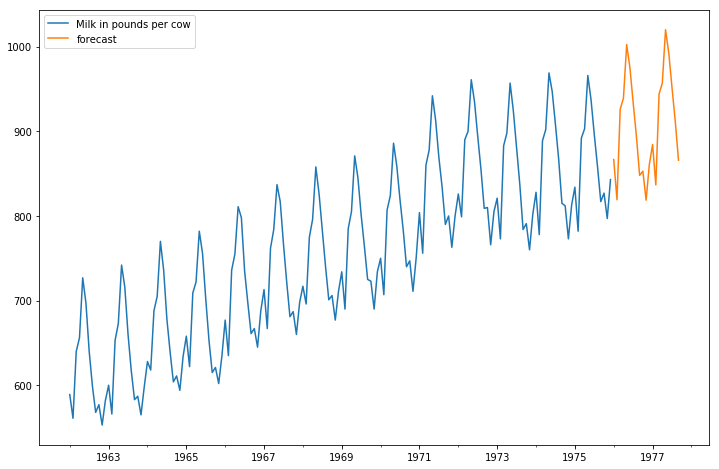

In [50]:
future_df['forecast'] = results.predict(start = 168, end = 188, dynamic= True)  
future_df[['Milk in pounds per cow', 'forecast']].plot(figsize=(12, 8)) 